In [1]:
import torch
from torch.utils.data import Subset, DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from simple_cnn import SimpleCNN
from finetuning_cnn import FineTuningCNN
from custom_cnn import CustomCNN


In [2]:
# Transformations: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [4]:
# --- Dataset base (senza transform) ---
dataset = ImageFolder(root='data')  # nessuna transform qui

# --- Carica lo split ---
split = torch.load('splits/dataset_split.pth')
train_indices = split['train_indices']
test_indices = split['test_indices']
label_map = split['label_map']

# --- Applica lo split ---
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, test_indices)

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform, label_map):
        self.subset = subset
        self.transform = transform
        self.label_map = label_map  # dizionario {label_originale: label_ricodificato}
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if label in self.label_map:
            mapped_label = self.label_map[label]
        else:
            # Label non autorizzata, assegna -1 o altra label "speciale"
            mapped_label = -1
        return self.transform(img), mapped_label

    def __len__(self):
        return len(self.subset)
    
# --- Applica le trasformazioni specifiche ---
train_data = TransformedSubset(train_subset, transform, label_map)

# --- Calcola il numero di classi a partire dal training set ---
all_labels = [label for _, label in train_subset]

num_classes = len(label_map)
print(f"Numero di classi (utenti autorizzati): {num_classes}")

val_data = TransformedSubset(val_subset, transform, label_map)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Numero di classi (utenti autorizzati): 127


In [5]:
# Caricamento del modello
model_path = './handwriting_identification_main_model.pth'
model_id_number = 1
#model = torch.load(model_path, map_location=torch.device('cpu'))
#model.eval()

# Load Dataset
data_dir = "./data"
dataset = ImageFolder(root=data_dir, transform=transform)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
if model_id_number == 1:
    model = SimpleCNN(num_classes=num_classes)
elif model_id_number == 2:
    #fine tuning model
    model = FineTuningCNN(num_classes=num_classes)
elif model_id_number == 3:
    #second architecture model
    model = CustomCNN(num_classes)
else:
    print("Invalid model_id_number")

c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

SimpleCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [63]:
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    auc, precision_score, recall_score, f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch

def evaluate_model(model, val_loader, threshold=0.5, device='cpu', print_summary=True, plot_roc=True):
    model.eval()
    total_auth = total_unauth = 0
    correct_auth = correct_total = 0
    false_accepts = false_rejects = 0

    confidences_correct = []
    confidences_incorrect = []

    all_preds = []
    all_labels = []
    all_confs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probs, dim=1)

            for i in range(labels.size(0)):
                label = labels[i].item()
                conf = max_probs[i].item()
                pred = predicted[i].item()

                # Applichiamo la soglia
                final_pred = pred if conf >= threshold else -1

                all_preds.append(final_pred)
                all_labels.append(label)
                all_confs.append(conf)

                # Metriche principali
                if label == -1:  # Non autorizzato
                    total_unauth += 1
                    if final_pred != -1:
                        false_accepts += 1
                        confidences_incorrect.append(conf)
                    else:
                        confidences_correct.append(conf)
                else:  # Autorizzato
                    total_auth += 1
                    if final_pred == label:
                        correct_auth += 1
                        confidences_correct.append(conf)
                    else:
                        false_rejects += 1
                        confidences_incorrect.append(conf)

                if (label != -1 and final_pred == label) or (label == -1 and final_pred == -1):
                    correct_total += 1

    # Valori binari: 1 = autorizzato, 0 = non autorizzato
    y_true = np.array([1 if l != -1 else 0 for l in all_labels])
    y_pred = np.array([1 if p != -1 else 0 for p in all_preds])
    y_scores = np.array(all_confs)

    # Metriche di classificazione
    overall_acc = 100 * correct_total / (total_auth + total_unauth) if (total_auth + total_unauth) > 0 else 0
    auth_acc = 100 * correct_auth / total_auth if total_auth > 0 else 0
    far = 100 * false_accepts / total_unauth if total_unauth > 0 else 0
    frr = 100 * false_rejects / total_auth if total_auth > 0 else 0
    precision = precision_score(y_true, y_pred, zero_division=0) * 100
    recall = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    cm = confusion_matrix(y_true, y_pred)

    avg_conf_correct = np.mean(confidences_correct) if confidences_correct else 0
    avg_conf_incorrect = np.mean(confidences_incorrect) if confidences_incorrect else 0

    # ROC & PR Curve
    roc_auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall_curve, precision_curve)

    if print_summary:
        print(f"\n--- Evaluation Results ---")
        print(f"Threshold: {threshold}")
        print(f"Authorized Accuracy: {auth_acc:.2f}%")
        print(f"False Accept Rate (FAR): {far:.2f}%")
        print(f"False Reject Rate (FRR): {frr:.2f}%")
        print(f"Overall Accuracy: {overall_acc:.2f}%")
        print(f"Precision: {precision:.2f}%")
        print(f"Recall (TPR): {recall:.2f}%")
        print(f"F1 Score: {f1:.2f}%")
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"PR AUC: {pr_auc:.2f}")
        print(f"Avg Confidence (Correct): {avg_conf_correct:.2f}")
        print(f"Avg Confidence (Incorrect): {avg_conf_incorrect:.2f}")
        print(f"Confusion Matrix:\n{cm}")

    # Output strutturato per eventuali plot successivi
    return {
        'authorized_accuracy': auth_acc,
        'far': far,
        'frr': frr,
        'overall_accuracy': overall_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'avg_conf_correct': avg_conf_correct,
        'avg_conf_incorrect': avg_conf_incorrect,
        'all_confs': all_confs,
        'all_labels': all_labels,
        'confusion_matrix': cm.tolist(),
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'roc_thresholds': roc_thresholds.tolist(),
        'precision_curve': precision_curve.tolist(),
        'recall_curve': recall_curve.tolist(),
        'pr_thresholds': pr_thresholds.tolist()
    }


In [64]:
metrics = evaluate_model(model, val_loader, threshold=0.6, device=device)


--- Evaluation Results ---
Threshold: 0.6
Authorized Accuracy: 94.67%
False Accept Rate (FAR): 28.12%
False Reject Rate (FRR): 5.33%
Overall Accuracy: 91.04%
Precision: 94.74%
Recall (TPR): 95.86%
F1 Score: 95.29%
ROC AUC: 0.94
PR AUC: 0.99
Avg Confidence (Correct): 0.90
Avg Confidence (Incorrect): 0.69
Confusion Matrix:
[[ 23   9]
 [  7 162]]


In [54]:
def print_evaluation_metrics(metrics):
    print("\n📊  EVALUATION SUMMARY")
    print("-" * 40)
    print(f"{'Authorized Accuracy':25}: {metrics['authorized_accuracy']:.2f}%")
    print(f"{'False Accept Rate (FAR)':25}: {metrics['far']:.2f}%")
    print(f"{'False Reject Rate (FRR)':25}: {metrics['frr']:.2f}%")
    print(f"{'Overall Accuracy':25}: {metrics['overall_accuracy']:.2f}%")
    print()
    print(f"{'Precision':25}: {metrics['precision']:.2f}%")
    print(f"{'Recall':25}: {metrics['recall']:.2f}%")
    print(f"{'F1 Score':25}: {metrics['f1']:.2f}%")
    print()
    print(f"{'Avg Confidence (Correct)':25}: {metrics['avg_conf_correct']:.3f}")
    print(f"{'Avg Confidence (Incorrect)':25}: {metrics['avg_conf_incorrect']:.3f}")
    print("-" * 40)


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels=['Non-Auth', 'Auth']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("🔍 Confusion Matrix (Binary: Auth vs Non-Auth)")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [56]:
def plot_metric_bars(metrics):
    names = ['Authorized Acc.', 'FAR', 'FRR', 'Overall Acc.', 'Precision', 'Recall', 'F1 Score']
    values = [
        metrics['authorized_accuracy'],
        metrics['far'],
        metrics['frr'],
        metrics['overall_accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1']
    ]

    colors = ['green', 'red', 'red', 'blue', 'orange', 'orange', 'purple']

    plt.figure(figsize=(10, 5))
    plt.bar(names, values, color=colors)
    plt.title("📈 Key Evaluation Metrics")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [57]:
def plot_evaluation_curves(metrics, title_prefix="Validation"):
    # Controllo che i dati necessari siano presenti
    if not all(key in metrics for key in ['fpr', 'tpr', 'precision_curve', 'recall_curve', 'roc_auc', 'pr_auc']):
        print("Metriche ROC/PR incomplete, impossibile plottare.")
        return

    fpr = metrics['fpr']
    tpr = metrics['tpr']
    precision_curve = metrics['precision_curve']
    recall_curve = metrics['recall_curve']
    roc_auc = metrics['roc_auc']
    pr_auc = metrics['pr_auc']

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate (FAR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, label=f"AUC = {pr_auc:.2f}", color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [58]:
def full_evaluation_report(metrics):
    print_evaluation_metrics(metrics)
    plot_evaluation_curves(metrics)
    plot_confusion_matrix(metrics['confusion_matrix'])
    plot_metric_bars(metrics)



📊  EVALUATION SUMMARY
----------------------------------------
Authorized Accuracy      : 94.67%
False Accept Rate (FAR)  : 28.12%
False Reject Rate (FRR)  : 5.33%
Overall Accuracy         : 91.04%

Precision                : 94.74%
Recall                   : 95.86%
F1 Score                 : 95.29%

Avg Confidence (Correct) : 0.903
Avg Confidence (Incorrect): 0.691
----------------------------------------


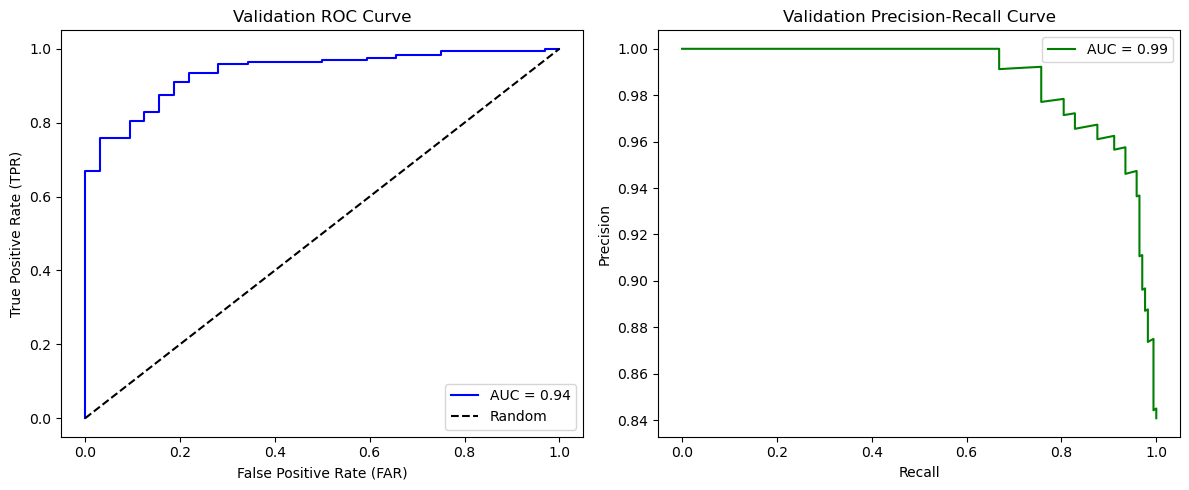

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_43392\41247499.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


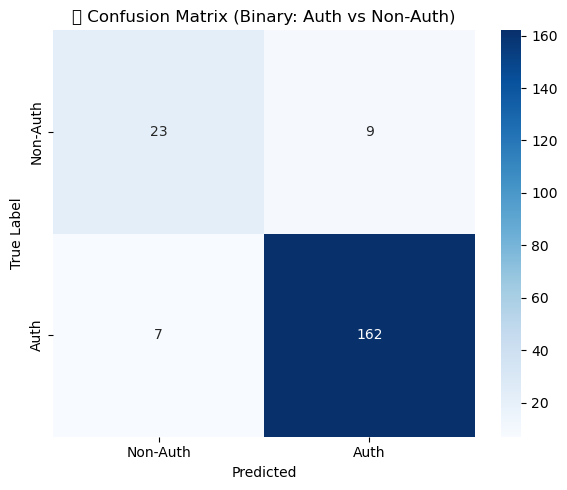

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_43392\1879087496.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


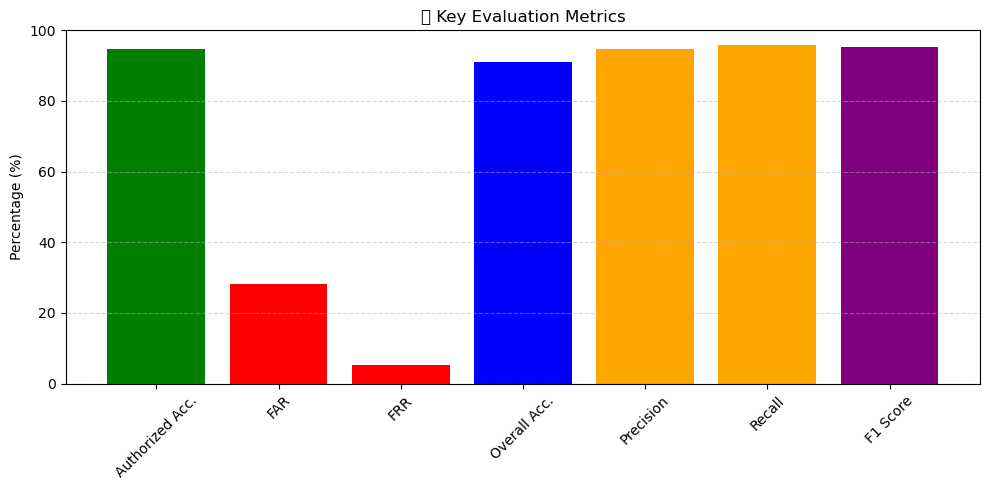

In [49]:
full_evaluation_report(metrics)

In [65]:
def plot_far_frr_vs_threshold_from_scores(y_true, y_scores):
    """
    Plot FAR and FRR in funzione della soglia.
    y_true: np.array, 1 = autorizzato, 0 = non autorizzato
    y_scores: np.array, confidenza del modello (es. softmax max probability)
    """
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    far = fpr * 100
    frr = (1 - tpr) * 100

    # Equal Error Rate (dove FAR ≈ FRR)
    eer_idx = np.nanargmin(np.abs(far - frr))
    eer_threshold = thresholds[eer_idx]
    eer = (far[eer_idx] + frr[eer_idx]) / 2

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, far, label="FAR (False Accept Rate)", color='red')
    plt.plot(thresholds, frr, label="FRR (False Reject Rate)", color='blue')
    plt.axvline(x=eer_threshold, linestyle='--', color='gray', label=f"EER Threshold = {eer_threshold:.2f}")
    plt.axhline(y=eer, linestyle='--', color='green', label=f"EER = {eer:.2f}%")

    plt.xlabel("Threshold")
    plt.ylabel("Error Rate (%)")
    plt.title("FAR and FRR vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


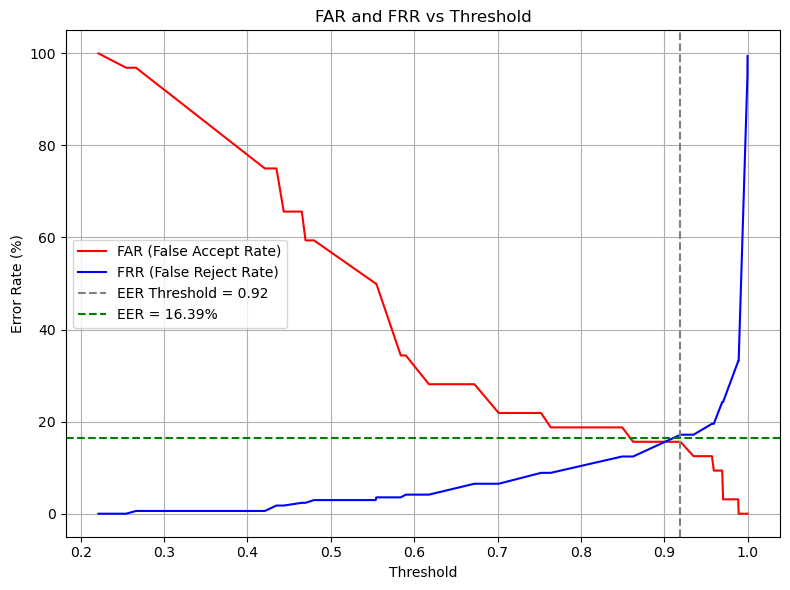

In [66]:
y_true = [1 if l != -1 else 0 for l in metrics['all_labels']]
y_scores = metrics['all_confs']
plot_far_frr_vs_threshold_from_scores(np.array(y_true), np.array(y_scores))